# Classificazione signers con rete neurale

## Import delle librerie

In [2]:
import itertools
import os

import numpy as np
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical

from handcrafted.app.dataset.dataset_loader import DatasetLoader
from handcrafted.app.dataset.utils.dataset_creator import DatasetCreator
from handcrafted.app.dataset.utils.frames_splitter import FramesSplitter
from handcrafted.app.model.model_statistics import ModelStatistics

## Caricamento del dataset
La classe [DatasetLoader](./handcrafted/app/dataset/dataset_loader.py) permette di caricare l'intero dataset direttamente da disco.
Questo è possibile in quanto basa il caricamento sulla struttura dei file e delle cartelle.

In [3]:
loader = DatasetLoader(directory="./data/frames_no_bg/")

12023it [22:00,  9.11it/s]


## Split del dataset
La classe [FramesSplitter](./handcrafted/app/dataset/utils/frames_splitter.py) permette di dividere il dataset in tre parti: training, validation e test.

In [4]:
num_signers = -1
if num_signers == -1:
    signers = loader.signers
    num_signers = loader.num_signers
else:
    signers = dict(itertools.islice(loader.signers.items(), num_signers))

In [5]:
splitter = FramesSplitter(signers, val_split=0.3, test_split=0.3, frames_to_extract=50, seed=42)

Tramite il metodo split viene suddiviso il dataset in tre parti: training, validation e test.
X_train_aug è una lista di augmentation da applicare a X_train, X_val_aug e X_test_aug contengono 0 in quanto non è necessario applicare augmentation al validation e test set.
X_train, X_val e X_test contengono il percorso delle immagini, in modo da non occupare spazio in memoria, e caricarle solo quando necessario.
Y_train, Y_val e Y_test contengono le label delle immagini.

In [6]:
X_train, X_train_aug, y_train, X_val, X_val_aug, y_val, X_test, X_test_aug, y_test = splitter.split()

100%|██████████| 78/78 [00:00<00:00, 95.43it/s]


In [7]:
# Get the total of different labels
num_classes = loader.num_signers
print(num_classes)

78


## Creazione del dataset
Inizialmente viene effettuato l'encoding delle label, andando a effettuare il one-hot encoding.

In [8]:
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.fit_transform(y_val)
y_test_encoded = label_encoder.fit_transform(y_test)
y_train_onehot = to_categorical(y_train_encoded, num_classes=num_classes)
y_val_onehot = to_categorical(y_val_encoded, num_classes=num_classes)
y_test_onehot = to_categorical(y_test_encoded, num_classes=num_classes)

Tramite la classe [DatasetCreator](./handcrafted/app/dataset/utils/dataset_creator.py) viene creato il dataset.
Si utilizza un [Dataset](https://www.tensorflow.org/api_docs/python/tf/data/Dataset) di TensorFlow, che permette di caricare i dati in modo efficiente e di applicare le augmentation in modo semplice e ottimizzato.

In [9]:
BATCH_SIZE = 512

dataset_creator = DatasetCreator()
train_dataset = dataset_creator.create_dataset(X_train, X_train_aug, y_train_onehot, batch_size=BATCH_SIZE, shuffle=True)
val_dataset = dataset_creator.create_dataset(X_val, X_val_aug, y_val_onehot, batch_size=BATCH_SIZE, shuffle=False)
test_dataset = dataset_creator.create_dataset(X_test, X_test_aug, y_test_onehot, batch_size=BATCH_SIZE, shuffle=False)

## Definizione del modello
La rete neurale è composta da tre blocchi convoluzionali, seguiti da un flatten e due dense layer.
Si tratta di una rete neurale semplice, in quanto il dataset è composto da immagini di dimensioni 224x224 e non è necessario utilizzare una rete più complessa.

In [11]:
def build_small_cnn(num_classes):
    model = keras.Sequential([
        layers.Input(shape=(224, 224, 3), name='input'),
        # First convolutional block
        layers.Conv2D(32, kernel_size=3, padding='same', activation='relu', name='conv1'),
        layers.MaxPooling2D(pool_size=2, strides=2, name='pool1'),
        # Second convolutional block
        layers.Conv2D(64, kernel_size=3, padding='same', activation='relu', name='conv2'),
        layers.MaxPooling2D(pool_size=2, strides=2, name='pool2'),
        # Third convolutional block
        layers.Conv2D(128, kernel_size=3, padding='same', activation='relu', name='conv3'),
        layers.MaxPooling2D(pool_size=2, strides=2, name='pool3'),
        # Flatten and dense layers
        layers.Flatten(name='flatten'),
        layers.Dense(128, activation='relu', name='fc1'),
        layers.Dropout(0.5, name='dropout'),
        layers.Dense(num_classes, activation='softmax', name='predictions')
    ])
    return model

## Compilazione del modello
Il modello viene compilato utilizzando la funzione di perdita `CategoricalCrossentropy`, l'ottimizzatore `adam` e la metrica `accuracy`.

In [12]:
strategy = tf.distribute.MirroredStrategy()
print('Number of available GPU:', strategy.num_replicas_in_sync)

Number of available GPU: 2


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1 (Conv2D)                       │ (None, 224, 224, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool1 (MaxPooling2D)                 │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2 (Conv2D)                       │ (None, 112, 112, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool2 (MaxPooling2D)                 │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3 (Conv2D)                       │ (None, 56, 56, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool3 (MaxPooling2D)                 │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 100352)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc1 (Dense)                          │ (None, 128)                 │      12,845,184 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ predictions (Dense)                  │ (None, 78)                  │          10,062 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 12,948,494 (49.39 MB)

 Trainable params: 12,948,494 (49.39 MB)

 Non-trainable params: 0 (0.00 B)

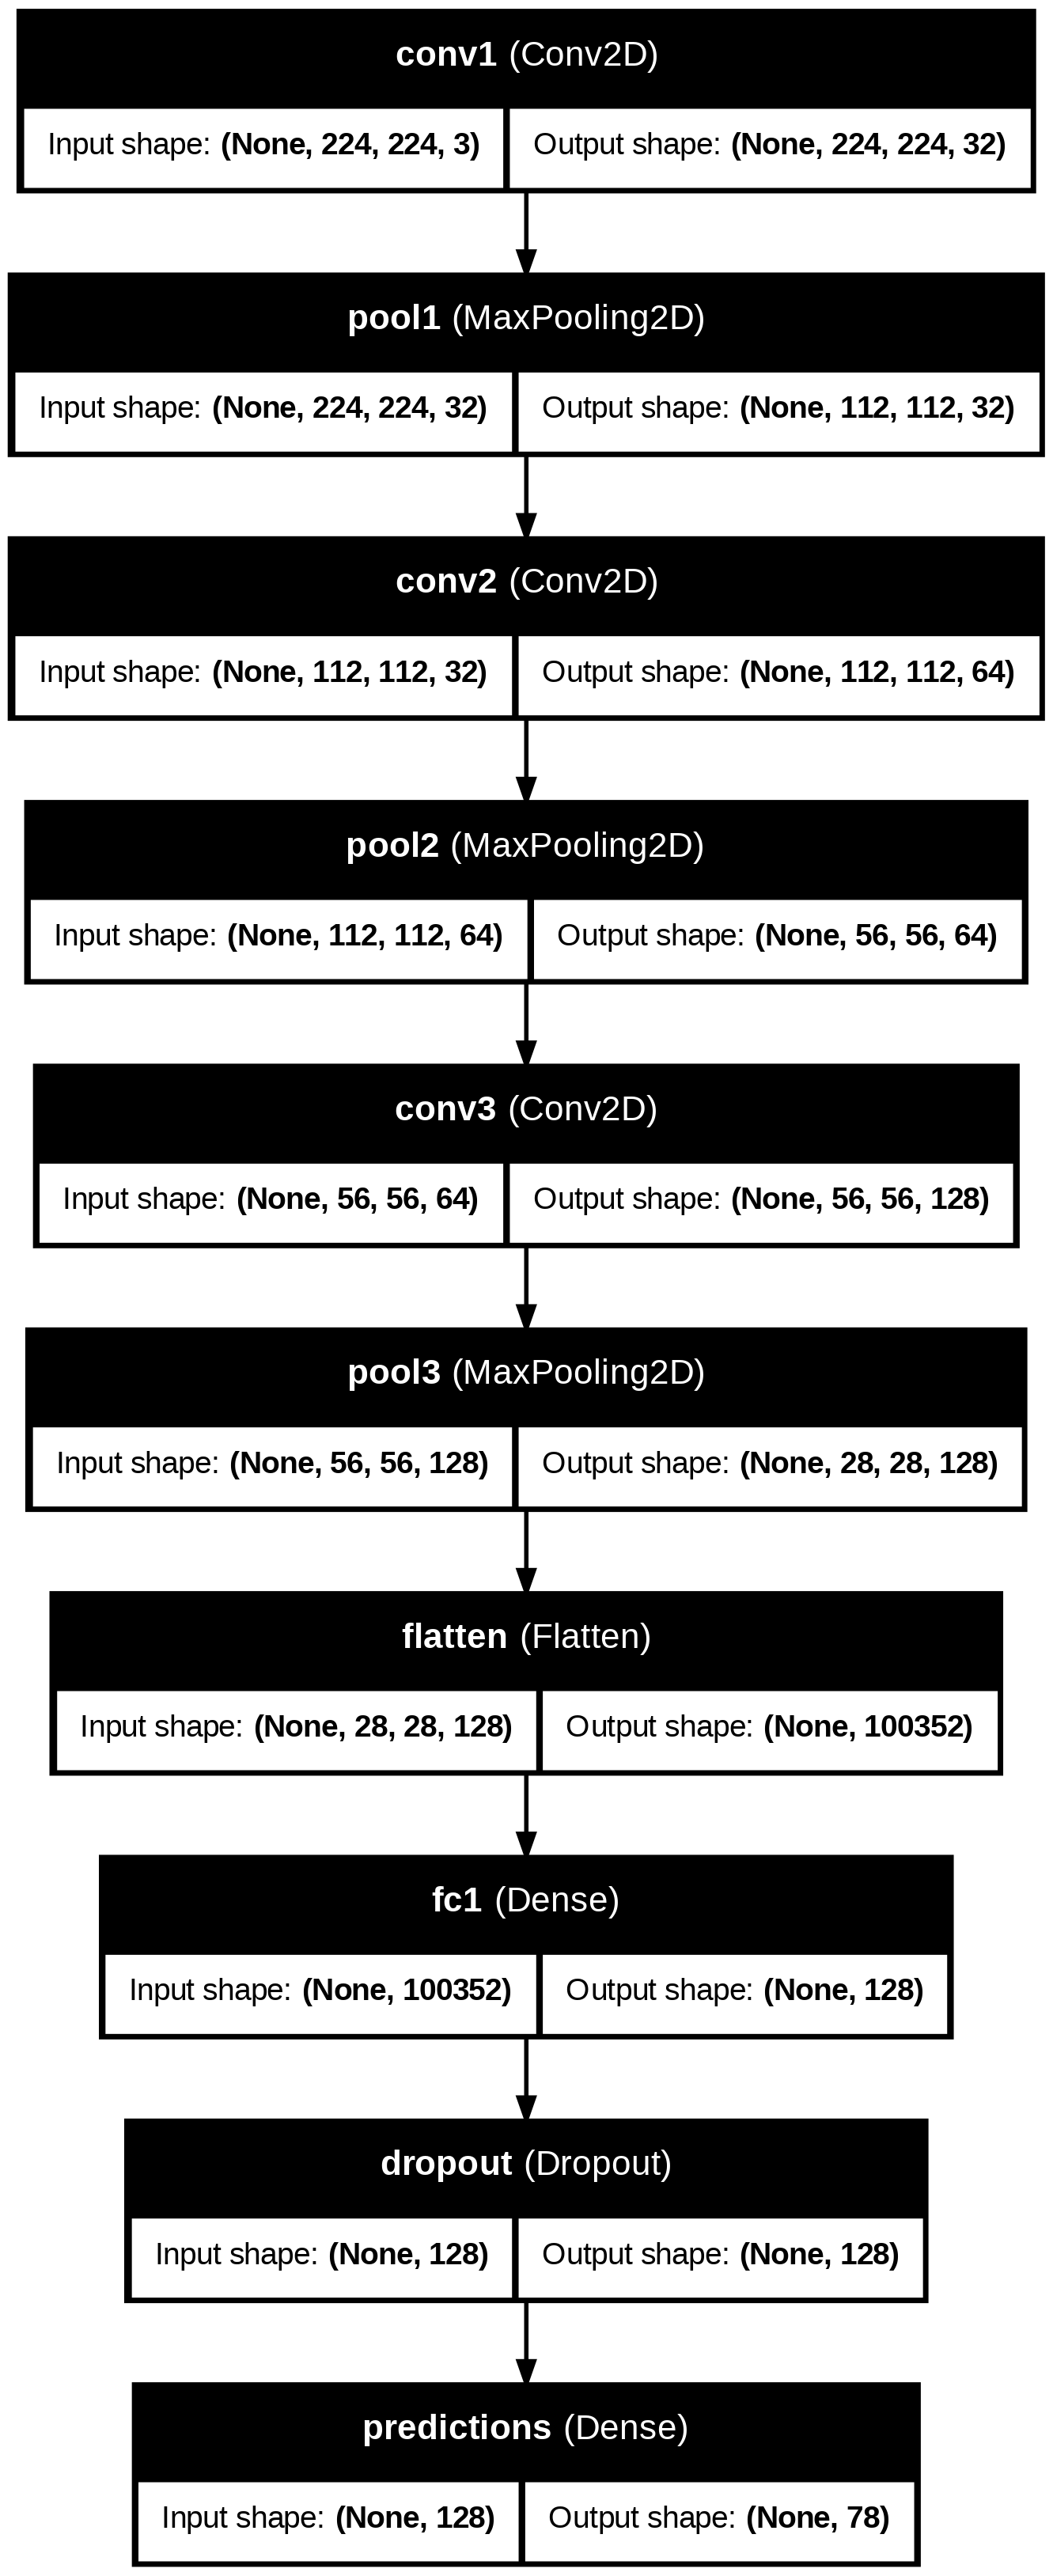

In [13]:
with strategy.scope():
    model = build_small_cnn(num_classes)
    model.compile(
        loss=keras.losses.CategoricalCrossentropy(),
        optimizer='adam',
        metrics=['accuracy']
    )

model.summary()
keras.utils.plot_model(model, show_shapes=True, show_layer_names=True)
# model.load_weights('vgg_face_weights.h5')

Viene creato un checkpoint per salvare il modello durante il training in caso il training venga interrotto.
Inoltre viene creato un early stopping che interrompe il training se la loss non migliora per 10 epoche.

In [14]:
checkpoint_filepath = "model.ckpt"
model_checkpoint = keras.callbacks.ModelCheckpoint(
    filepath=os.path.join(checkpoint_filepath, 'model_{epoch:02d}.weights.h5'),
    save_weights_only=True,
    save_best_only=True,
    monitor='val_loss',
    mode='min',
)

early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    mode='min',
    patience=10,
    restore_best_weights=True
)

## Training del modello
Il training del modello viene effettuato tramite il metodo `fit` di Keras.
Il training viene effettuato in batch, in modo da non occupare troppo spazio in memoria.
Il training viene effettuato per 100 epoche, ma grazie all'early stopping il training si interrompe se la loss non migliora per 10 epoche.

In [15]:
history = model.fit(
    train_dataset,
    epochs=100,
    # steps_per_epoch=(len(X_train) * NUM_AUG) // BATCH_SIZE,
    validation_data=val_dataset,
    callbacks=[model_checkpoint, early_stopping],
    verbose=1,
)

Epoch 1/100
    523/Unknown 1714s 3s/step - accuracy: 0.7152 - loss: 1.2965

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


523/523 ━━━━━━━━━━━━━━━━━━━━ 2235s 4s/step - accuracy: 0.7155 - loss: 1.2952 - val_accuracy: 0.9680 - val_loss: 0.1333
Epoch 2/100
523/523 ━━━━━━━━━━━━━━━━━━━━ 1480s 3s/step - accuracy: 0.9557 - loss: 0.1309 - val_accuracy: 0.9765 - val_loss: 0.1190
Epoch 3/100
523/523 ━━━━━━━━━━━━━━━━━━━━ 1725s 3s/step - accuracy: 0.9703 - loss: 0.0863 - val_accuracy: 0.9801 - val_loss: 0.1041
Epoch 4/100
523/523 ━━━━━━━━━━━━━━━━━━━━ 1560s 3s/step - accuracy: 0.9766 - loss: 0.0635 - val_accuracy: 0.9810 - val_loss: 0.1083
Epoch 5/100
523/523 ━━━━━━━━━━━━━━━━━━━━ 1574s 3s/step - accuracy: 0.9819 - loss: 0.0486 - val_accuracy: 0.9810 - val_loss: 0.1243
Epoch 6/100
523/523 ━━━━━━━━━━━━━━━━━━━━ 1562s 3s/step - accuracy: 0.9840 - loss: 0.0421 - val_accuracy: 0.9837 - val_loss: 0.1130
Epoch 7/100
523/523 ━━━━━━━━━━━━━━━━━━━━ 1506s 3s/step - accuracy: 0.9863 - loss: 0.0385 - val_accuracy: 0.9816 - val_loss: 0.1297
Epoch 8/100
523/523 ━━━━━━━━━━━━━━━━━━━━ 1551s 3s/step - accuracy: 0.9874 - loss: 0.0356 - val_

## Valutazione del modello
Il modello viene valutato utilizzando il test set.
Si può osservare come `accuracy` e `loss` siano in linea con i risultati ottenuti sul validation set durante il training, e non si discostano troppo da quelli ottenuti sul training set, il che indica che il modello non è andato in overfitting.

In [16]:
test_loss, test_acc = model.evaluate(test_dataset)

328/328 ━━━━━━━━━━━━━━━━━━━━ 1121s 3s/step - accuracy: 0.9775 - loss: 0.1147


## Predizione del modello
Il modello viene utilizzato per effettuare la predizione sul test set.

In [17]:
y_pred = model.predict(test_dataset)

328/328 ━━━━━━━━━━━━━━━━━━━━ 664s 2s/step


Si va quindi a trasformare la predizione ottenuta nel formato originale, in modo da poterla confrontare con le label originali.

In [18]:
y_pred_indices = np.argmax(y_pred, axis=1)
y_pred_original = label_encoder.inverse_transform(y_pred_indices)

In [19]:
print(len(y_test))
print(len(y_pred_original))

167789
167789


## Visualizzazione dei risultati
Tramite la classe [ModelStatistics](./handcrafted/app/model/model_statistics.py) viene stampato l'andamento di `loss` e `accuracy` durante il training.

In [20]:
stats = ModelStatistics(save_name=f"svc_signer_test_{len(y_test)}", save_dir="signer/plots")

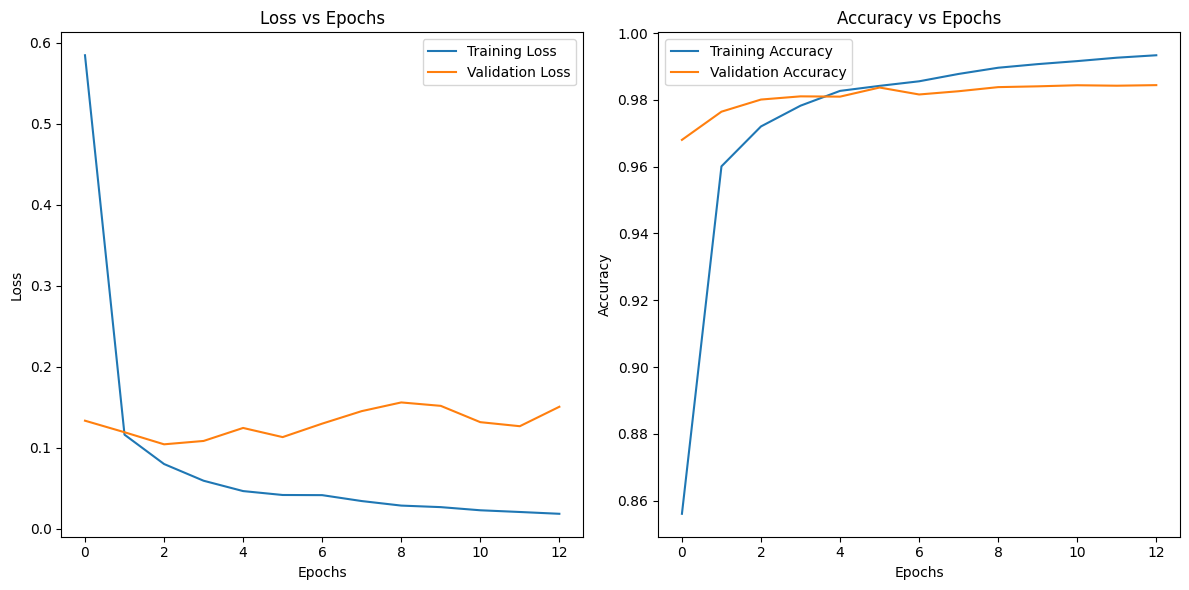

In [21]:
stats.plot_history(history=history)

Viene inoltre utilizzato anche per stampare l'accuratezza del modello e per visualizzare la matrice di confusione.
La matrice di confusione permette di osservare come il modello non abbia grandi difficoltà nel classificare i signer e sia riuscito a generalizzare bene.

Accuracy: 97.75%
Confusion matrix saved at signer/plots/svc_signer_test_167789.png


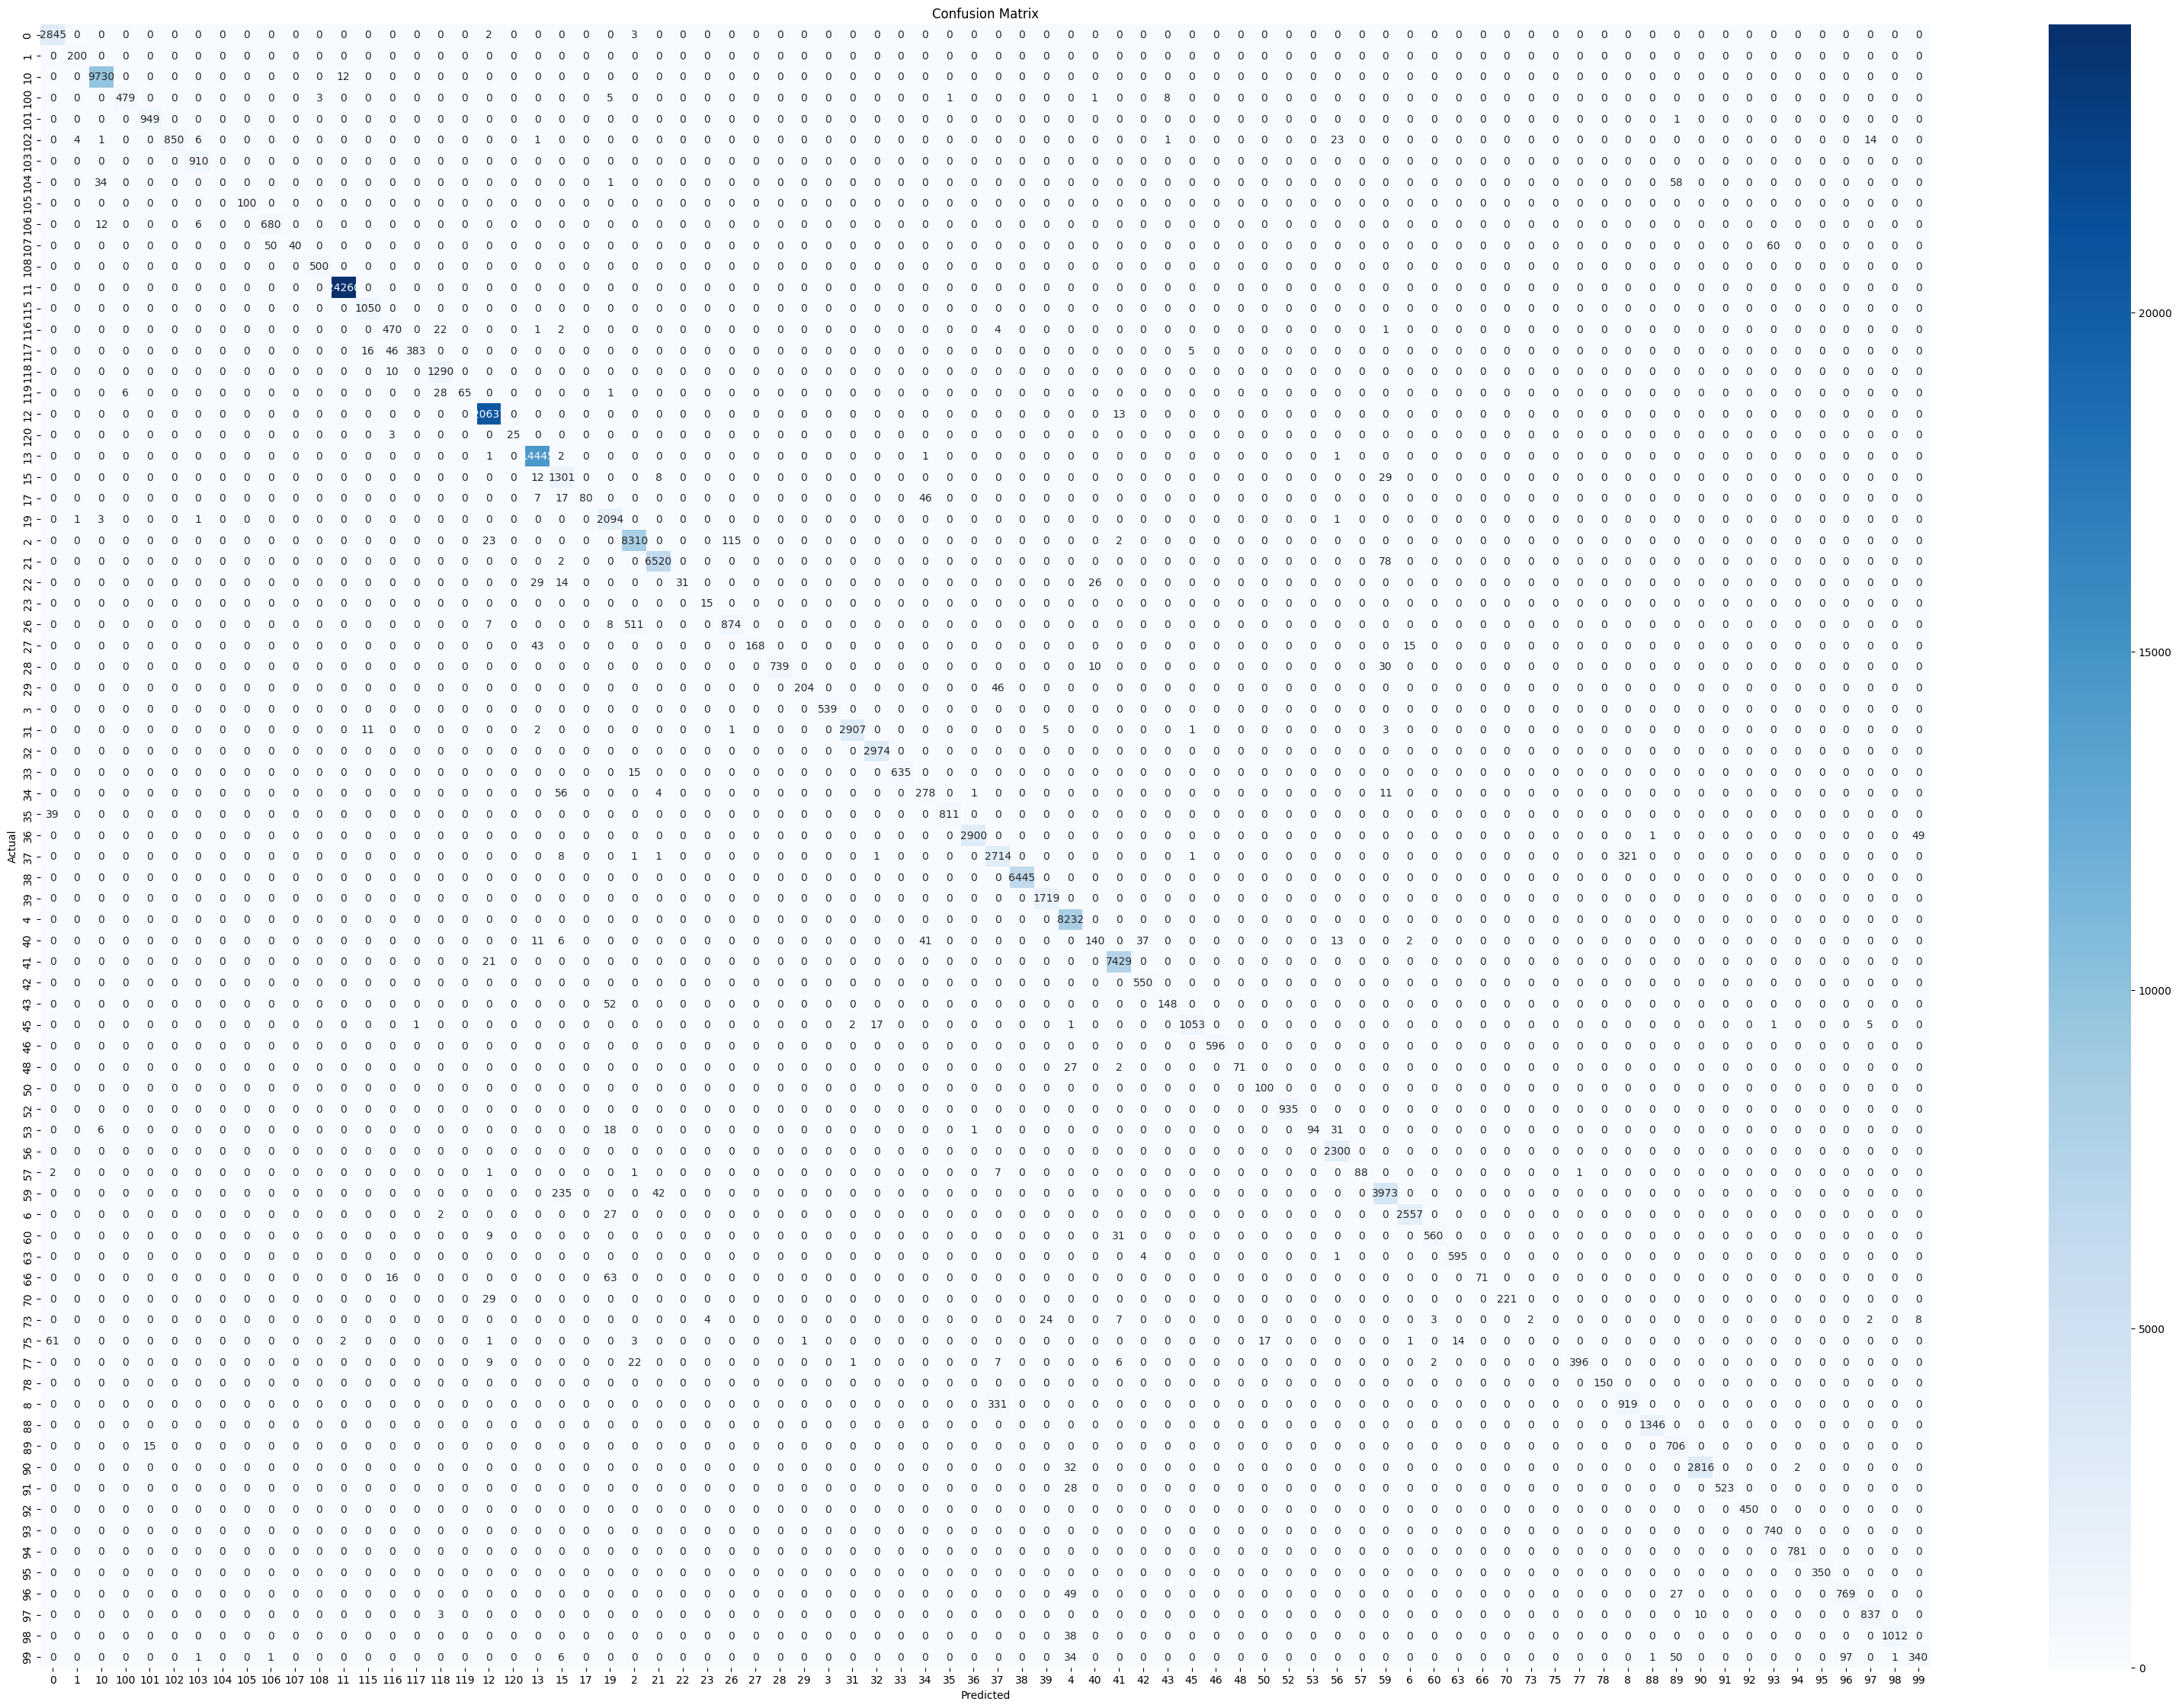

In [22]:
stats.print_accuracy(y_test, y_pred_original)
stats.plot_confusion_matrix(y_test, y_pred_original, save=True, plot=True, figsize=(40,28))